In [1]:
import pandas as pd
import numpy as np
from openeye import oechem, oedepict, oemolprop
import oenotebook as oenb
import matplotlib.pyplot as plt
import pickle
%matplotlib inline

## 1. Filtering by logP

In [2]:
###### IMPORT PKA FILTERED MOLECULE LIST FROM CSV FILE ######
df_pKa = pd.read_csv("df_pKa_interval_3-11_spread.csv")

df_XlogP = df_pKa.loc[:, ("eMolecules ID", "canonical isomeric SMILES", "eMolecules SMILES", "pKas in [3,11]")]

print("Initial number of molecules: ", df_XlogP.shape[0])
# df_XlogP.head()

# make new column for XlogP data 
df_XlogP["XlogP"] = None

for i, row in enumerate(df_XlogP.iterrows()):
    smiles = df_XlogP.loc[i,"canonical isomeric SMILES"]
    mol = oechem.OEGraphMol()
    oechem.OESmilesToMol(mol, str(smiles))
    
    try: 
        logP=oemolprop.OEGetXLogP(mol)
    except RuntimeError:
            print("Error: i=",i," ", df_molecules.ix[i, "NAME"])
            logP=float("NaN")
            
    df_XlogP.loc[i,"XlogP"] = float(logP)
    del mol
df_XlogP.head()

Initial number of molecules:  180


,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP
0,7616001,c1cc2c(c(sc2nc1)C(=O)N)N,NC(=O)c1sc2c(c1N)cccn2,"[3.454, 10.685]",0.257
1,1570822,c1cc2cccnc2c(c1)NC(=O)c3ccc(cc3)Cl,Clc1ccc(cc1)C(=O)Nc1cccc2c1nccc2,[3.95],3.588
2,44750813,Cc1cnc(s1)Nc2ccccn2,Cc1cnc(s1)Nc1ccccn1,"[3.718, 6.011]",1.472
3,859659,c1ccc(cc1)c2cc(c(s2)N)C(=O)N,NC(=O)c1cc(sc1N)c1ccccc1,[9.967],2.157
4,1155596,COc1ccc(cc1)NC(=O)/C=C/c2ccccc2,COc1ccc(cc1)NC(=O)/C=C/c1ccccc1,[5.1],3.48


In [3]:
##### ELIMINATE MOLECULES OUTSIDE ACCEPTABLE LOGP INTEVAL: -1 <= logP <= 6  #####

# Select molecules within desired logP interval
df_XlogP_interval = df_XlogP.loc[(-1 <= df_XlogP["XlogP"])]
df_XlogP_interval = df_XlogP_interval.loc[(df_XlogP_interval["XlogP"] <= 6)].reindex()

print("Number of molecules in logP interval: ", df_XlogP_interval.shape[0])

# Save dataframe of molecules that are withing XlogP interval criteria.
df_XlogP_interval.to_csv("df_XlogP_interval.csv")

df_XlogP_interval.head()

Number of molecules in logP interval:  178


,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP
0,7616001,c1cc2c(c(sc2nc1)C(=O)N)N,NC(=O)c1sc2c(c1N)cccn2,"[3.454, 10.685]",0.257
1,1570822,c1cc2cccnc2c(c1)NC(=O)c3ccc(cc3)Cl,Clc1ccc(cc1)C(=O)Nc1cccc2c1nccc2,[3.95],3.588
2,44750813,Cc1cnc(s1)Nc2ccccn2,Cc1cnc(s1)Nc1ccccn1,"[3.718, 6.011]",1.472
3,859659,c1ccc(cc1)c2cc(c(s2)N)C(=O)N,NC(=O)c1cc(sc1N)c1ccccc1,[9.967],2.157
4,1155596,COc1ccc(cc1)NC(=O)/C=C/c2ccccc2,COc1ccc(cc1)NC(=O)/C=C/c1ccccc1,[5.1],3.48


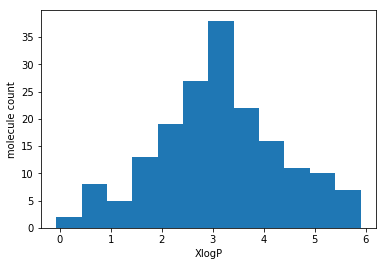

In [4]:
XlogP_values = df_XlogP_interval.loc[:, "XlogP"]
plt.hist(XlogP_values, bins=12)
plt.xlabel("XlogP")
plt.ylabel("molecule count")

## 2. Filtering by Molecular Weight

In [5]:
df_eMol = pd.read_csv("isosmiles-list-search-tier1-100mg.csv")
df_eMol_mw = df_eMol.loc[:,("eMolecules ID","MolWt","Availability (mg)", "Price")]

# Merge dataframes based on eMolecules ID
df_mw = df_XlogP_interval.merge(df_eMol_mw, on="eMolecules ID")
df_mw.head()

,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price
0,7616001,c1cc2c(c(sc2nc1)C(=O)N)N,NC(=O)c1sc2c(c1N)cccn2,"[3.454, 10.685]",0.257,193.226,970.0,168.0
1,1570822,c1cc2cccnc2c(c1)NC(=O)c3ccc(cc3)Cl,Clc1ccc(cc1)C(=O)Nc1cccc2c1nccc2,[3.95],3.588,282.724,176.0,168.0
2,44750813,Cc1cnc(s1)Nc2ccccn2,Cc1cnc(s1)Nc1ccccn1,"[3.718, 6.011]",1.472,191.253,1015.0,168.0
3,859659,c1ccc(cc1)c2cc(c(s2)N)C(=O)N,NC(=O)c1cc(sc1N)c1ccccc1,[9.967],2.157,218.275,19471.5,223.0
4,1155596,COc1ccc(cc1)NC(=O)/C=C/c2ccccc2,COc1ccc(cc1)NC(=O)/C=C/c1ccccc1,[5.1],3.48,253.296,100.0,168.0


In [6]:
# I will group compounds according to molecular weight into 2 groups.
# Fragment-like: 150<= mw <350
# Drug-like: 350< mw <=500

df_mw["group"] = None
for i, row in enumerate(df_mw.iterrows()):
    mw =df_mw.loc[i,"MolWt"]
    if (150 <= mw) and (mw < 350):
        df_mw.loc[i,"group"]= "fragment-like"
    elif (380 < mw) and (mw <= 500):
        df_mw.loc[i,"group"]= "drug-like"
    else:
        continue

df_mw.to_csv("df_mw.csv", index=False)        
df_mw.head()

,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price,group
0,7616001,c1cc2c(c(sc2nc1)C(=O)N)N,NC(=O)c1sc2c(c1N)cccn2,"[3.454, 10.685]",0.257,193.226,970.0,168.0,fragment-like
1,1570822,c1cc2cccnc2c(c1)NC(=O)c3ccc(cc3)Cl,Clc1ccc(cc1)C(=O)Nc1cccc2c1nccc2,[3.95],3.588,282.724,176.0,168.0,fragment-like
2,44750813,Cc1cnc(s1)Nc2ccccn2,Cc1cnc(s1)Nc1ccccn1,"[3.718, 6.011]",1.472,191.253,1015.0,168.0,fragment-like
3,859659,c1ccc(cc1)c2cc(c(s2)N)C(=O)N,NC(=O)c1cc(sc1N)c1ccccc1,[9.967],2.157,218.275,19471.5,223.0,fragment-like
4,1155596,COc1ccc(cc1)NC(=O)/C=C/c2ccccc2,COc1ccc(cc1)NC(=O)/C=C/c1ccccc1,[5.1],3.48,253.296,100.0,168.0,fragment-like


In [7]:
df_frag = df_mw.loc[df_mw["group"] == "fragment-like"]
print("Number of compounds suitable for fragment-like group: ", df_frag.shape[0])

df_drug = df_mw.loc[df_mw["group"] == "drug-like"]
print("Number of compounds suitable for drug-like group: ", df_drug.shape[0])

Number of compounds suitable for fragment-like group:  126
Number of compounds suitable for drug-like group:  25


(0, 6)

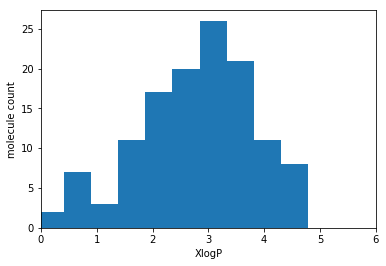

In [8]:
# Let's check the logP distribution of fragment-like group
XlogP_values = df_frag.loc[:, "XlogP"]
plt.hist(XlogP_values, bins=10)
plt.xlabel("XlogP")
plt.ylabel("molecule count")
plt.xlim(0,6)

(0, 6)

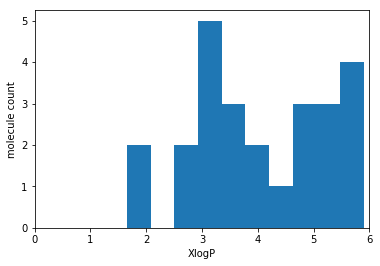

In [9]:
# Let's check the logP distribution of drug-like group
XlogP_values = df_drug.loc[:, "XlogP"]
plt.hist(XlogP_values, bins=10)
plt.xlabel("XlogP")
plt.ylabel("molecule count")
plt.xlim(0,6)

In [10]:
df_drug

,eMolecules ID,canonical isomeric SMILES,eMolecules SMILES,"pKas in [3,11]",XlogP,MolWt,Availability (mg),Price,group
21,10748986,Cc1cccc(c1NC(=O)c2cnc(s2)Nc3cc(nc(n3)C)N4CCN(C...,OCCN1CCN(CC1)c1cc(nc(n1)C)Nc1ncc(s1)C(=O)Nc1c(...,"[6.992, 8.185]",1.887,488.006,NaN,148.0,drug-like
22,1415746,COc1ccc(cc1)c2c3c(ncnc3oc2c4ccc(cc4)OC)NCCO,OCCNc1ncnc2c1c(c1ccc(cc1)OC)c(o2)c1ccc(cc1)OC,[4.829],2.794,391.420,398.0,168.0,drug-like
29,3365457,CCOc1ccc2c(c1)sc(n2)NC(=O)Cc3ccc(c(c3)Cl)Cl,CCOc1ccc2c(c1)sc(n2)NC(=O)Cc1ccc(c(c1)Cl)Cl,[9.167],5.171,381.276,489.9,148.0,drug-like
37,2183015,c1cc(ccc1CSc2nnc(s2)NC(=O)c3ccc(cc3)Cl)Br,Clc1ccc(cc1)C(=O)Nc1nnc(s1)SCc1ccc(cc1)Br,[6.888],5.9,440.765,482.2,400.0,drug-like
48,4424334,c1ccc2c(c1)c(nnc2Nc3ccc(c(c3)Cl)Cl)c4ccc(cc4)C...,NC(=O)c1ccc(cc1)c1nnc(c2c1cccc2)Nc1ccc(c(c1)Cl)Cl,[5.578],4.27,409.268,308.0,168.0,drug-like
50,17664146,CN1CCN(CC1)c2c(cccc2Cl)NC(=O)c3ccc(o3)Br,CN1CCN(CC1)c1c(cccc1Cl)NC(=O)c1ccc(o1)Br,[7.773],3.109,398.682,379.0,168.0,drug-like
61,46568819,c1cc(cc(c1)OCc2ccc(cc2Cl)Cl)/C=C/3\C(=O)NC(=O)S3,O=C1NC(=O)/C(=C\c2cccc(c2)OCc2ccc(cc2Cl)Cl)/S1,[8.05],5.238,380.245,154.0,219.0,drug-like
67,5551808,Cc1ccc2c(c1)sc(n2)NC(=O)Cc3csc(n3)NC(=O)Nc4ccc...,O=C(Nc1nc2c(s1)cc(cc2)C)Cc1csc(n1)NC(=O)Nc1ccc...,"[8.865, 10.738]",4.809,457.956,148.0,400.0,drug-like
72,18897105,c1ccc2c(c1)c(=O)[nH]c(n2)CCC(=O)Nc3ncc(s3)Cc4c...,O=C(Nc1ncc(s1)Cc1ccc(c(c1)F)F)CCc1nc2ccccc2c(=...,"[9.381, 10.773]",3.341,426.439,247.7,223.0,drug-like
76,4375254,CCOC(=O)c1ccc(cc1)Nc2cc(nc(n2)Nc3ccc(cc3)C(=O)...,CCOC(=O)c1ccc(cc1)Nc1cc(C)nc(n1)Nc1ccc(cc1)C(=...,[6.336],2.937,420.461,319.0,168.0,drug-like
